## Import Libraries 

In [45]:
# Import Lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
import csv

from xgboost import XGBClassifier

# Importing the dataset
dataset_train = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv', header=None)

# Take all columns except last one
train = dataset_train.iloc[:, :-1]
test = dataset_test.iloc[:, :]
y = dataset_train.iloc[:, dataset_train.shape[1]-1]


## Data Analysis

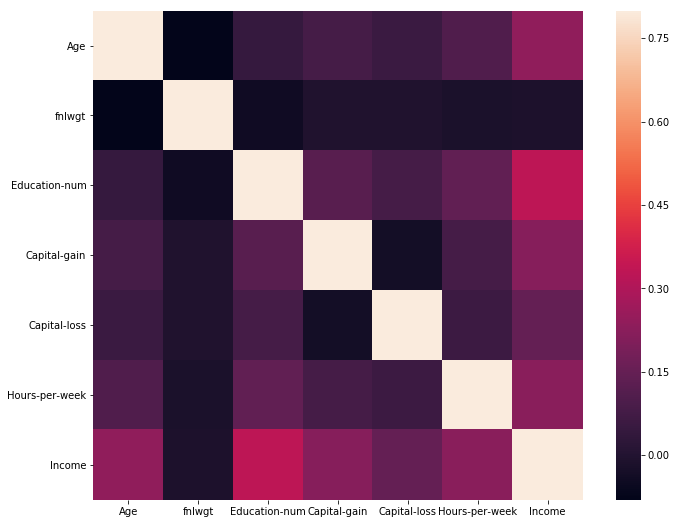

In [46]:
import seaborn as sns
import matplotlib.pyplot as pplt
#correlation matrix
corrmat = dataset_train.corr()
f, ax = pplt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
    

## Data preprocessing

In [47]:
# Encoding categorial data
# Replace string by categories number
drop = []
train_objs_num = len(train)

dataset = pd.concat(objs=[train, test], axis=0)

# Salary Mapping
edu_mapping = {
        ' Preschool':0, 
        ' 1st-4th':1,
        ' 5th-6th':2,
        ' 7th-8th':3,
        ' 9th':4,
        ' 10th':5,
        ' 11th':6,
        ' 12th':7,
        ' HS-grad':15,
        ' Prof-school':70,
        ' Assoc-acdm':25,
        ' Assoc-voc':25,
        ' Some-college':20,
        ' Bachelors':40,
        ' Masters':55,
        ' Doctorate':70
}
gender_mapping = {
    ' Female':10,
    ' Male':30
}
color_mapping = {
    ' Amer-Indian-Eskimo':11,
    ' White':25, 
    ' Asian-Pac-Islander':25, 
    ' Other':10, 
    ' Black':13
}
marital_mapping={
    ' Married-civ-spouse':45,
    ' Divorced':10,
    ' Never-married':5,
    ' Separated':6,
    ' Widowed':8,
    ' Married-spouse-absent':8,
    ' Married-AF-spouse':45
}
dataset[3] = dataset[3].map(edu_mapping)
dataset[9] = dataset[9].map(gender_mapping)
dataset[8] = dataset[8].map(color_mapping)
dataset[5] = dataset[5].map(marital_mapping)

income_minus = dataset.values[:,10] - dataset.values[:,11]
min_value = min(income_minus)
dataset.loc[:, 10] = (income_minus.astype(int) - min_value)
# One hot encoder
'''
for row in range(0, dataset.shape[1]):
    if (isinstance(dataset.values[1][row], str)):        
        print ("Delete row: ", row), 
        one_hot = pd.get_dummies(dataset[row])
        drop.append(row)
        dataset = pd.concat([dataset, one_hot], axis=1)
        dataset = dataset.iloc[:, :-1]
    
# Remove original attributes
drop.sort(reverse=True)
for row in drop:
    dataset = dataset.drop(row, axis = 1)
'''

# Only label encoder
for row in range(0, dataset.shape[1]):
    if (isinstance(dataset.values[1][row], str)): 
        print (row),
        labelencoder = LabelEncoder()
        target = labelencoder.fit_transform(dataset.values[:, row])
        dataset[row] = target
dataset = dataset.drop(11, axis = 1)

print ("Finish One Hot Enconding")

# PCA
'''
n_com = 30
pca = PCA(n_components=n_com)
dataset_pca = pca.fit_transform(dataset)
print ("Finish PCA preprocess") 
'''

C:\Users\tony\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


ValueError: cannot convert float NaN to integer

## XGBOOST

In [39]:
X = dataset[:train_objs_num]
test_data = dataset[train_objs_num:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
xgbc = XGBClassifier(max_depth=10)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, xgbc.predict(X_train)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std_pred = xgbc.predict(test_data)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

C:\Users\tony\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Misclassified sample 425


C:\Users\tony\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train Accuracy:  0.903784049424319
Test Accuracy:  0.8657612128869235
precision:  0.8657612128869235
recall:  0.8657612128869235
fscore:  0.8657612128869235
Done


C:\Users\tony\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## SVM

In [36]:
X = dataset[:train_objs_num]
test_data = dataset[train_objs_num:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

#feature normalize
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

svm = SVC(kernel='rbf')
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, svm.predict(X_train_std)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std = sc.transform(test_data)
test_std_pred = svm.predict(test_std)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

Misclassified sample 512
Train Accuracy:  0.8459000280819995
Test Accuracy:  0.8382817435249527
precision:  0.8382817435249527
recall:  0.8382817435249527
fscore:  0.8382817435249527
Done


## Random Forest Tree

In [25]:
X = dataset[:train_objs_num]
test_data = dataset[train_objs_num:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
'''
max_fscore = 0
target_n_estimators = 0
for i in range(10, 100):
    forest = RandomForestClassifier(criterion='entropy', n_estimators=i)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
    if fscore > max_fscore:
        max_fscore = fscore
        target_n_estimators = i
'''    
forest = RandomForestClassifier(criterion='entropy', n_estimators=20)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print ("Misclassified sample %d" % (y_test!=y_pred).sum())
print ("Train Accuracy: ", accuracy_score(y_train, forest.predict(X_train)))
print ("Test Accuracy: ", accuracy_score(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
print ("precision: ", precision)
print ("recall: ", recall)
print ("fscore: ", fscore)


test_std_pred = forest.predict(test_data)

with open('output.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'ans'])
    for i in range(len(test_std_pred)):
        writer.writerow([i, test_std_pred[i]])

print ("Done")

Misclassified sample 942
Train Accuracy:  0.9953796943490107
Test Accuracy:  0.8512083399147055
precision:  0.8512083399147055
recall:  0.8512083399147055
fscore:  0.8512083399147055
Done


## Data analysis

In [27]:
target_attribute = 1
dic = dict()
for i in range(0, dataset_train.shape[0]):
    if (dataset_train.values[i][14] == 1):
        string = dataset_train.values[i][target_attribute]
        if string in dic:
            dic[string] += 1
        else:
            dic[string] = 1